# 데이터 준비

In [2]:
import numpy as np
import os
import re
import shutil
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print(tf.__version__)

2.4.1


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"



#untar=True는 압축을 풀어준다는 의미 같음.
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 2s 0us/step


In [6]:
os.listdir(dataset_dir)

['README', 'test', 'imdbEr.txt', 'train', 'imdb.vocab']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_neg.txt',
 'unsup',
 'unsupBow.feat',
 'labeledBow.feat',
 'neg',
 'urls_pos.txt',
 'pos']

# 데이터 전처리

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [10]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [13]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [14]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [17]:
max_features = 10000 #만개의 단어를 가지고 문장들의 라벨을 판단하겠다는 의미.
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [18]:
#라벨 없이 텍스트만 있는 데이터 셋 만들기

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [19]:
#최종적으로 텍스트를 벡터로 만들어주는 함수 
#0,1(부정, 긍정)을 쌍으로 반환함.

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [24]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [25]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [26]:
#데이터셋 완성

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#나중에 컴퓨터가 모델을 못 따라간다면 prefetch를 빼도 됨.

# Model

In [28]:
embedding_dim = 16

In [29]:
#첫 레이어 : 임베딩/인풋-max_features +1,아웃풋-embedding_dim
#두번째 레이어 : Dropout/ 10개가 들어오면 2개는 0으로 대체, 나머지 8개에 대해서만 보겠다는 것.
#dropout이 오버피팅을 막아주기 때문에 중요함.
#세번째 레이어 : 긍정부정 파악 시 여러 단어를 한 차원으로 합친 후 긍정,부정 중 가까운 곳에.
#네번재 레이어 : Dense

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [32]:
from tensorflow.keras import losses

#from_logits=True 로 하면서 값을 0~1 사이의 값으로 반환 받아 확률로 나타냄.
#이걸 사용하면 Dense 뒤에 아무것도 붙이지 않아도 확률로 반환 받을 수 있음.
#0,1로 판단하는 이진이기 때문에 BinaryCross~ 쓴 것.
model.compile(loss = losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [33]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6823 - binary_accuracy: 0.6147 - val_loss: 0.6140 - val_binary_accuracy: 0.7744
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5786 - binary_accuracy: 0.7851 - val_loss: 0.4973 - val_binary_accuracy: 0.8224
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4641 - binary_accuracy: 0.8360 - val_loss: 0.4193 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3897 - binary_accuracy: 0.8632 - val_loss: 0.3732 - val_binary_accuracy: 0.8594
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3425 - binary_accuracy: 0.8776 - val_loss: 0.3447 - val_binary_accuracy: 0.8660
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3105 - binary_accuracy: 0.8887 - val_loss: 0.3258 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

## 모델 평가

In [34]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3102 - binary_accuracy: 0.8737
Loss:  0.3102380335330963
Accuracy:  0.8736799955368042


In [35]:
# .history를 통해서 4가지 지표가 쌓여 딕셔너리 형태로 들어가 있음.
#딕셔너리에서 key만 뽑으면 loss, binary_accuracy등 4가지 지표를 볼 수 있음

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [36]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

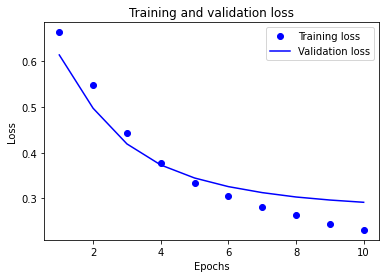

In [37]:
#과적합 판단을 위해 loss와 accuracy 표로 나타내기

#loss 표로 나타내기

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#둘 다 감소하는 경향을 보임
#validation loss는 에폭 4에서부터 완만하므로 과적합이라고 판단할 수 있음.

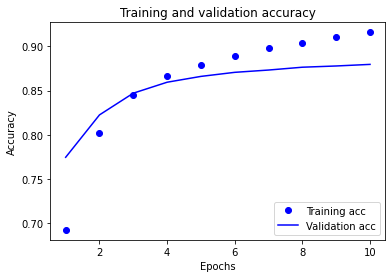

In [38]:
#accuracy 표로 나타내기

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

#둘 다 증가하는 경향이지만 둘의 차이만큼이 과적합이라고 생각할 수 있을 듯.

## 모델 예측

In [39]:
#sigmoid ; 0~1사이의 값만 존재.
#위에서 값을 0~1 사이의 값으로 반환하여 확률로 나타내도록 해서 binary까지 썼으니 sigmoid를 써 주는 것이 좋음
#최근에는 렐루를 더 많이 쓰긴 함.
#특정 케이스에서는 sigmoid를 써야할 때가 있음.

export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])


#sigmoid를 썼기 때문에 다시 값을 0~1 사이의 값으로 바꿀 필요가 없어서 False를 써 준 것.
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)


loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3074 - accuracy: 0.8765
0.8736799955368042


## 예시 적용

In [48]:
#새로운 데이터 정의
examples = [
  "The movie was very nice!",
  "The movie was so so.",
  "The movie was suck..."
]

#새로운 데이터 모델에 적용
export_model.predict(examples)

#긍정이면 0.5보다 높고 1에 가깝게 나올 것
#애매모호한 표현이면 0.5 언저리 일 것
#부정이면 0.5보다 낮고 0에 가깝게 나올 것

array([[0.5744191 ],
       [0.4803629 ],
       [0.42915377]], dtype=float32)

- 분류인지 이진 문제인지 파악 후 써야하는 활성화 함수를 판단하면 됨.
- Crossentropy(from_logits = True/False)는 잘 기억해둬야 할 듯.
- 확률로 값을 나타내야 하니까 0~1 사이의 값으로 바꿔줘야만 오류가 안남.